Image Filter / Image Kernel Overview 

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import make_grid

import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline

c:\Users\ASUS\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
transform=transforms.ToTensor()

In [3]:

train_dataset = datasets.MNIST(root='./cnn_data', train=True, download=True, transform=transform)

In [4]:
#Test dataset
test_dataset = datasets.MNIST(root='./cnn_data', train=False, download=True, transform=transform)

In [5]:
train_dataset

Dataset MNIST
    Number of datapoints: 60000
    Root location: ./cnn_data
    Split: Train
    StandardTransform
Transform: ToTensor()

In [6]:
test_dataset

Dataset MNIST
    Number of datapoints: 10000
    Root location: ./cnn_data
    Split: Test
    StandardTransform
Transform: ToTensor()

In [7]:
train_loader = DataLoader(dataset=train_dataset, batch_size=10, shuffle=True)
test_loader=DataLoader(dataset=test_dataset, batch_size=10, shuffle=False)

In [8]:
#create data loader for creating small batches of images ... lets say 10 images at a time
#Describe Convolutional Layer and what it does (2 CL)
conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=3, stride=1)
conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=3, stride=1)#, padding=0

In [9]:
#Grab 1 MNSIT image and pass it through the conv layer
for i, (X_Train, y_Train) in enumerate(train_dataset):
        break

In [10]:
X_Train.shape

torch.Size([1, 28, 28])

In [11]:
x=X_Train.view(1, 1, 28, 28)  # Reshape to match the input shape of Conv2d (N, C, H, W)

In [12]:
#perform convolution
x=F.relu(conv1(x))  # Apply first convolutional layer with ReLU activation


In [13]:
x.shape  # Check the shape after the first convolutional layer
# 1 image (1, 6, 26, 26) - 6 is filter ,26*26 is the output size after convolution

torch.Size([1, 6, 26, 26])

In [14]:
x=F.max_pool2d(x, kernel_size=2, stride=2)  # Apply max pooling with a 2x2 kernel and stride of 2

In [15]:
x.shape #26/2 = 13, 26/2 = 13, so output is (1, 6, 13, 13) after pooling

torch.Size([1, 6, 13, 13])

In [16]:
x=F.relu(conv2(x))  # Apply second convolutional layer with ReLU activation

In [17]:
x.shape

torch.Size([1, 16, 11, 11])

In [18]:
#Pool again
x=F.max_pool2d(x, kernel_size=2, stride=2)

In [19]:
x.shape

torch.Size([1, 16, 5, 5])

In [20]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=3, stride=1)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=3, stride=1)
        self.fc1 = nn.Linear( 5 * 5 * 16, 120)  # Adjusted for the output size after pooling
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, kernel_size=2, stride=2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, kernel_size=2, stride=2)
        x = x.view(-1, 16 * 5 * 5)  # Flatten the tensor
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return F.log_softmax(x, dim=1)  # Use log_softmax for multi-class classification

In [21]:
torch.manual_seed(41)
model = CNN()
model

# Automatically select GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Move model to device
model = model.to(device)


In [22]:
criterion = nn.CrossEntropyLoss()  # Use CrossEntropyLoss for multi-class classification
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)  # Use Adam optimizer

In [ ]:
import time
start_time = time.time()

# Automatically select GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Create variables to track metrics
epochs = 5
train_losses = []
test_losses = []
train_correct = []
test_correct = []

for i in range(epochs):
    trn_corr = 0
    trn_loss = 0

    model.train()  # Set model to training mode

    for b, (X_Train, y_Train) in enumerate(train_loader):
        b += 1

        #  Move data to device
        X_Train, y_Train = X_Train.to(device), y_Train.to(device)

        # Reshape the data
        X_Train = X_Train.view(-1, 1, 28, 28)

        # Forward pass
        y_pred = model(X_Train)
        loss = criterion(y_pred, y_Train)
        predicted = torch.max(y_pred, 1)[1]
        batch_corr = (predicted == y_Train).sum()
        trn_corr += batch_corr
        trn_loss += loss.item()

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Print progress
        if b % 600 == 0:
            print(f"Epoch: {i+1}/{epochs} | Batch: {b}/{len(train_loader)} | "
                  f"Loss: {loss.item():.4f} | Train Accuracy: {trn_corr.float()/len(train_loader.dataset):.4f}")

    train_losses.append(trn_loss / len(train_loader))
    train_correct.append(trn_corr.float() / len(train_loader.dataset))

    # 🔍 Evaluation mode
    model.eval()
    tst_corr = 0
    tst_loss = 0

    with torch.no_grad():
        for X_Test, y_Test in test_loader:
            #  Move data to device
            X_Test, y_Test = X_Test.to(device), y_Test.to(device)

            X_Test = X_Test.view(-1, 1, 28, 28)
            y_test_pred = model(X_Test)
            loss = criterion(y_test_pred, y_Test)
            predicted = torch.max(y_test_pred, 1)[1]
            tst_corr += (predicted == y_Test).sum()
            tst_loss += loss.item()

    test_losses.append(tst_loss / len(test_loader))
    test_correct.append(tst_corr.float() / len(test_loader.dataset))

current_time = time.time()
print("Time taken to run the code: {:.2f} seconds".format(current_time - start_time))


Epoch: 1/5 | Batch: 600/6000 | Loss: 0.1600 | Train Accuracy: 0.0740
Epoch: 1/5 | Batch: 1200/6000 | Loss: 0.1824 | Train Accuracy: 0.1659
Epoch: 1/5 | Batch: 1800/6000 | Loss: 0.4986 | Train Accuracy: 0.2607
Epoch: 1/5 | Batch: 2400/6000 | Loss: 0.1704 | Train Accuracy: 0.3563
Epoch: 1/5 | Batch: 3000/6000 | Loss: 0.0070 | Train Accuracy: 0.4523
Epoch: 1/5 | Batch: 3600/6000 | Loss: 0.4515 | Train Accuracy: 0.5490
Epoch: 1/5 | Batch: 4200/6000 | Loss: 0.0044 | Train Accuracy: 0.6456
Epoch: 1/5 | Batch: 4800/6000 | Loss: 0.0011 | Train Accuracy: 0.7431
Epoch: 1/5 | Batch: 5400/6000 | Loss: 0.0584 | Train Accuracy: 0.8406
Epoch: 1/5 | Batch: 6000/6000 | Loss: 0.0006 | Train Accuracy: 0.9377
Epoch: 2/5 | Batch: 600/6000 | Loss: 0.0047 | Train Accuracy: 0.0975
Epoch: 2/5 | Batch: 1200/6000 | Loss: 0.3186 | Train Accuracy: 0.1955
Epoch: 2/5 | Batch: 1800/6000 | Loss: 0.0037 | Train Accuracy: 0.2933
Epoch: 2/5 | Batch: 2400/6000 | Loss: 0.0035 | Train Accuracy: 0.3913
Epoch: 2/5 | Batch: 30

In [24]:
if next(model.parameters()).is_cuda:
    print("Model is on CUDA (GPU)")
else:
    print("Model is on CPU")


Model is on CUDA (GPU)


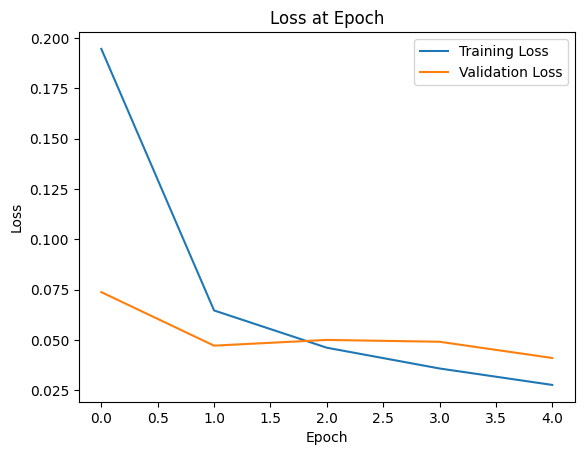

In [25]:
plt.plot(train_losses, label="Training Loss")
plt.plot(test_losses, label="Validation Loss")
plt.title("Loss at Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()


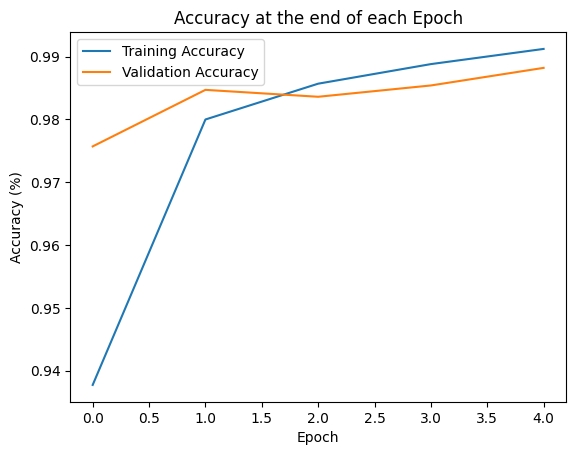

In [26]:
# Convert to floats (from CUDA tensors) for plotting
train_acc = [t.cpu().item() if torch.is_tensor(t) else t for t in train_correct]
test_acc = [t.cpu().item() if torch.is_tensor(t) else t for t in test_correct]

# Plot the accuracy (already in % if you followed previous advice)
plt.plot(train_acc, label="Training Accuracy")
plt.plot(test_acc, label="Validation Accuracy")
plt.title("Accuracy at the end of each Epoch")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.legend()
plt.show()


In [27]:
test_load_everything = DataLoader(test_dataset, batch_size=10000, shuffle=False)

In [ ]:
with torch.no_grad():
    correct = 0
    total = 0
    model.eval()  # Set to evaluation mode

    for X_test, y_test in test_load_everything:
        # Move inputs and labels to the same device as the model
        X_test = X_test.to(device)
        y_test = y_test.to(device)

        X_test = X_test.view(-1, 1, 28, 28)  # If needed by your model
        y_val = model(X_test)
        predicted = torch.max(y_val, 1)[1]
        correct += (predicted == y_test).sum().item()  # .item() to get the number
        total += y_test.size(0)

    accuracy = 100 * correct / total
    print(f"Accuracy on full test set: {accuracy:.2f}%")
    print(f"correct: {correct}")
    print(f"total : {total}")


Accuracy on full test set: 98.82%
correct: 9882
total : 10000


In [ ]:
correct += (predicted == y_test).sum().item()
correct


29646

In [33]:
total

10000

Get prediction on an img

In [38]:
#Grab an image from the test set
test_dataset[4143]

(tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 

In [39]:
test_dataset[4143][0].shape

torch.Size([1, 28, 28])

In [40]:
test_dataset[4143][0].reshape(28, 28)  # Reshape to match the input shape 

tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000

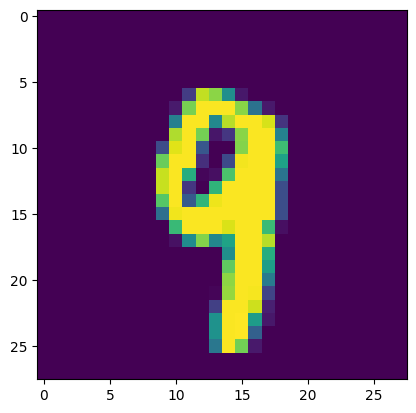

In [41]:
plt.imshow(test_dataset[4143][0].reshape(28, 28))

In [ ]:
model.eval()
with torch.no_grad():
    image = test_dataset[4143][0].to(device)  #  Move input to GPU
    image = image.view(1, 1, 28, 28)           # Batch size of 1, correct shape
    new_prediction = model(image)
    predicted_label = torch.argmax(new_prediction, dim=1).item()
    print(f"new_prediction: {new_prediction}")
    print(f"Predicted label: {predicted_label}")


new_prediction: tensor([[-2.3962e+01, -2.3500e+01, -2.4171e+01, -1.5404e+01, -1.1874e+01,
         -1.9907e+01, -3.5216e+01, -1.7303e+01, -1.5491e+01, -7.3909e-06]],
       device='cuda:0')
Predicted label: 9
